# [EDA] Spatial Contexts for Los Angeles

In [12]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

%matplotlib inline
plt.style.use('fivethirtyeight')

## CalEPA Data

### GeoPandas DataFrame of LA County

In [13]:
# Original Pandas df of Los Angeles 
ces_la = pd.read_csv("../data/CalEPA/ces_losangeles.csv", index_col=0)

In [14]:
# Convert to GeoPandas with coordinates (longitude, latitude)
gpd_la = gpd.GeoDataFrame(ces_la, geometry=gpd.points_from_xy(ces_la.Longitude, ces_la.Latitude))

In [15]:
gpd_la.head()

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile Range,Ozone,...,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%),geometry
0,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,95-100% (highest scores),0.048,...,13.34,72.59,14.07,97.27,1.71,0.84,0.0,0.00,0.18,POINT (-118.19750 34.01750)
1,6037542402,3306,Los Angeles,90221,Compton,-118.212413,33.881969,80.71,95-100% (highest scores),0.043,...,11.34,77.53,11.13,65.34,0.54,33.55,0.0,0.57,0.00,POINT (-118.21241 33.88197)
2,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,95-100% (highest scores),0.042,...,18.60,72.48,8.92,78.14,1.09,15.67,0.0,4.84,0.25,POINT (-118.23003 33.87986)
3,6037203300,2000,Los Angeles,90033,Los Angeles,-118.207788,34.058872,77.35,95-100% (highest scores),0.049,...,7.70,84.50,7.80,75.55,2.85,10.45,0.0,6.95,4.20,POINT (-118.20779 34.05887)
4,6037291220,3640,Los Angeles,90247,Los Angeles,-118.286709,33.877139,77.25,95-100% (highest scores),0.041,...,12.77,73.16,14.07,69.34,3.98,8.43,0.0,16.32,1.92,POINT (-118.28671 33.87714)


### Shapefile of LA County

In [16]:
shape_la = gpd.read_file("../data/LAShape/County_Boundary.shp")

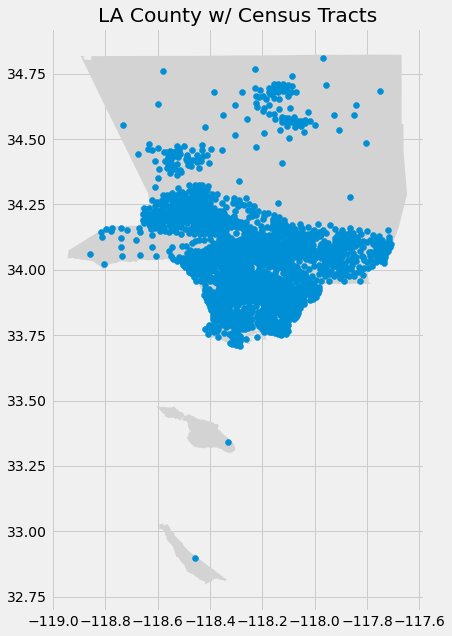

In [17]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(ax=ax)
plt.title("LA County w/ Census Tracts");

## Shapefile of LA County w/ CES 4.0, Pollution Burden, and Population Characteristics Scores

As we recall from the CalEPA, A CES 4.0 Score is assigned based on `Pollution Burden Score` * `Population Characteristic Score`. So when we break them up, what do we get? What do we visually see?

### CES 4.0 Scores

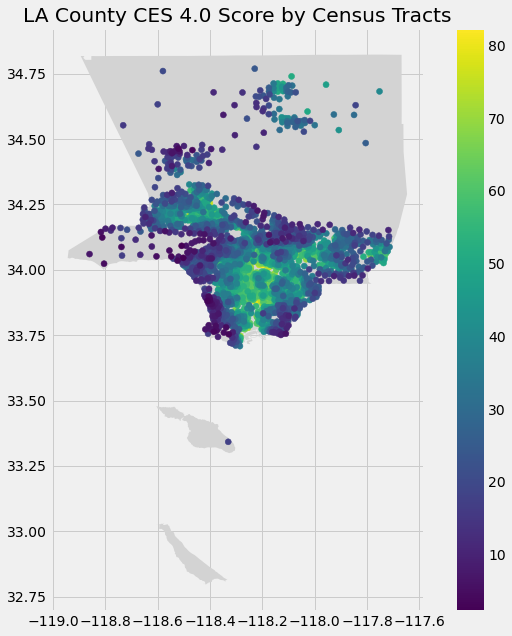

In [18]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(column='CES 4.0 Score', ax=ax, legend=True)
plt.title("LA County CES 4.0 Score by Census Tracts");

### Pollution Burden Scores
**Exposure + Environmental Effects Indicators**

"Pollution Burden scores for each census tract are derived from the average percentiles of the seven Exposures indicators (ozone and PM2.5 concentrations, diesel PM emissions, drinking water contaminants, children’s lead risk from housing, pesticide use, toxic releases from facilities, and traffic density) and the five Environmental Effects indicators (cleanup sites, impaired water bodies, groundwater threats, hazardous waste facilities and generators, and solid waste sites and facilities). 

Indicators from the Environmental Effects component were given half the weight of the indicators from the Exposures component. The calculated average pollution burden score (average of the indicators) was divided by 10 and rounded to one decimal place for a Pollution Burden score ranging from 0.1 – 10." (CalEPA CalEnviroScreen 148).

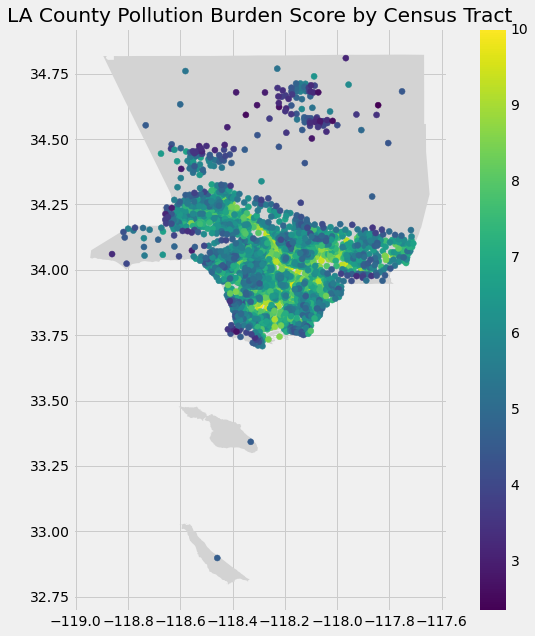

In [19]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(column='Pollution Burden Score', ax=ax, legend=True)
plt.title("LA County Pollution Burden Score by Census Tract");

### Population Characteristic Scores
**Sensitive Population + Socioeconomic Factor Indicators**

"Population Characteristics scores for each census tract are derived from the average percentiles for the three Sensitive Populations indicators (asthma, cardiovascular disease, and low birth weight) and the five Socioeconomic Factors indicators (educational attainment, housing-burdened low-income households, linguistic isolation, poverty, and unemployment). The calculated average percentile divided by 10 for a Population Characteristic score ranging from 0.1 – 10" (CalEPA CalEnviroScreen 198).

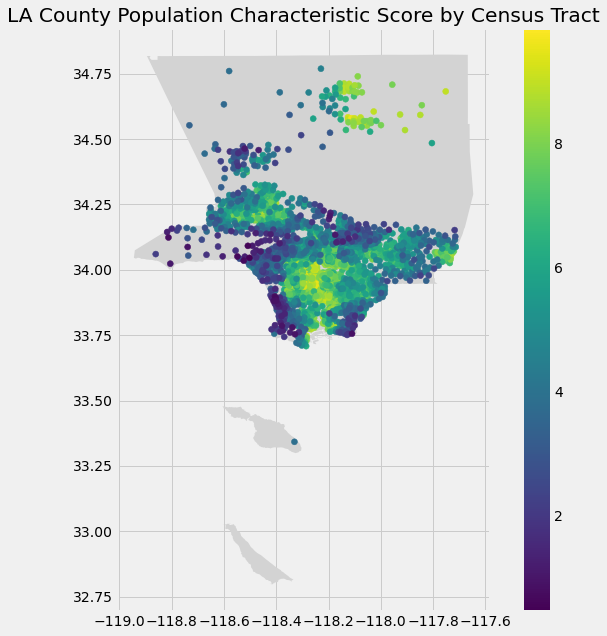

In [20]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(column='Pop. Char. Score', ax=ax, legend=True)
plt.title("LA County Population Characteristic Score by Census Tract");

## Deeper look into Population Chateristics

The CalEPA constructs its scores using the Pollution Burden * Population Characteristics method based on existing scientific literature, risk assessment principles, and established risk scoring systems. Here, Pollution Burden is the multiplicand and Population Characteristics is the multiplier based on the idea that "existing research on environmental pollutants and health risk has consistently identified socioeconomic and sensitivity factors as 'effect modifiers' that multiply the risks posed by the pollutants" (CalEPA CalEnviroScreen 13). 

Scientific literature and principles back this understanding when it comes to making sense of environmental inequity. But, as we dive deeper to the history of Los Angeles, a lot of the environmental inequity was built purposefully; privileging a few and harming specific populations. Do we see these inequities across certain socioeconomic groups visually? And if so, what can we learn, and what can modeling help us discover later on?  

The racial/ethnic makeup of LA County predominantly Hispanic and White (non-Hispanic), followed by Asian (non-Hispanic), Black (non-Hispanic), and Native American (non-Hispanic). 

Let's first look at the highest correlation to CES 4.0 Score: Hispanic (%) and White (%). Both were identified with a correlation coefficient |r| ~ 0.7. 

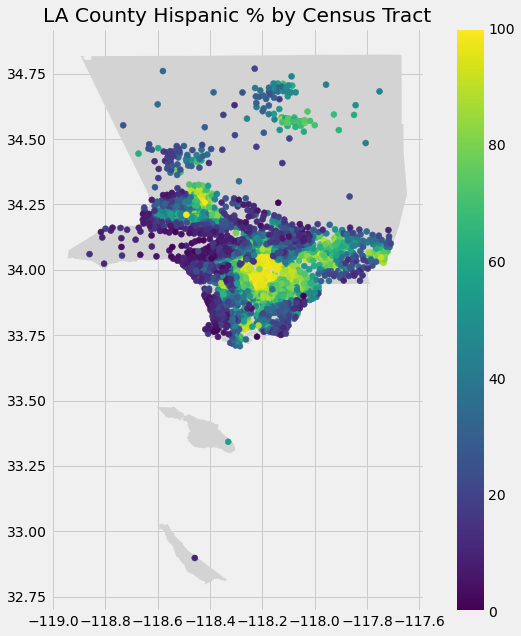

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(column='Hispanic (%)', ax=ax, legend=True)
plt.title("LA County Hispanic % by Census Tract");

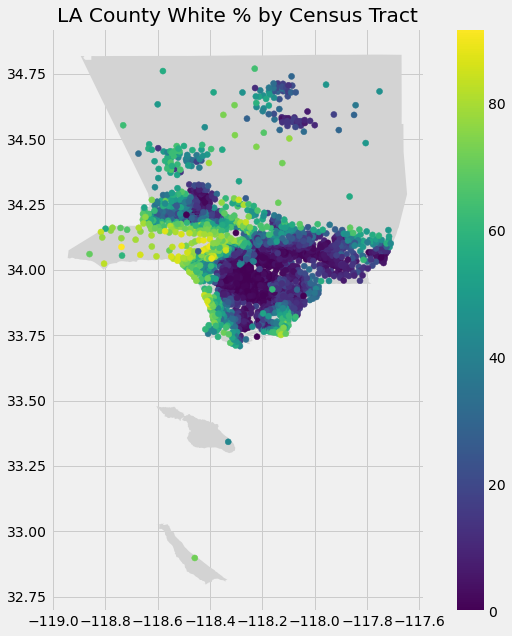

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(column='White (%)', ax=ax, legend=True)
plt.title("LA County White % by Census Tract");

The Hispanic and White percentages appear inverted spatially.